# MUWCLASS_CSCv2
 
## Classifying Unidentified X-ray Sources in the Chandra Source Catalog Using a Multi-wavelength Machine Learning Approach

### Hui Yang<sup>1</sup>, Jeremy Hare<sup>2</sup>, Oleg Kargaltsev<sup>1</sup>, Steven Chen<sup>1</sup>, Igor Volkov<sup>1</sup>,  Blagoy Rangelov<sup>3</sup>, Yichao Lin<sup>1</sup>,
<sup>1</sup>The George Washington University <sup>2</sup>NASA GSFC <sup>3</sup>Texas State University

## CHECK our [MUWCLASS paper](https://ui.adsabs.harvard.edu/abs/2022ApJ...941..104Y/abstract)
## Related Papers: [NGC 3532](https://ui.adsabs.harvard.edu/abs/2023ApJ...948...59C/abstract), [13 FGL-LAT source](https://ui.adsabs.harvard.edu/abs/2024ApJ...961...26R/abstract), [Visualization tool](https://ui.adsabs.harvard.edu/abs/2021RNAAS...5..102Y/abstract), [4XMM-DR13 TD](https://ui.adsabs.harvard.edu/abs/2024arXiv240215684L/abstract)
## Visualization Tools : [CSCv2.0 Training Dataset](https://muwclass.github.io/XCLASS_CSCv2/), [4XMM-DR13 Training Dataset](https://yichaolin-astro.github.io/4XMM-DR13-XCLASS/), [4FGL-DR4 catalog visualization](https://muwclass.github.io/GCLASS/), [Classification of CSCv2.0 Sources within Unidentified 4FGL-DR4 Sources](https://muwclass.github.io/MUWCLASS_4FGL-DR4/)

### contact huiyang@gwu.edu if you have any questions

--- 

This github repo provides the MUltiWavelength Machine Learning CLASSification Pipeline (MUWCLASS) and the classification results on the Chandra Source Catalog v2 (CSCv2).

The main components of this github repo are

demos/
- There are notebooks of demonstrations of classifying CSCv2 sources using MUWCLASS with CSCv2 and multiwavelength data

files/{CSC_TD_11042023_MW_allcolumns.csv, tbabs.data}
- Some other CSV files including the raw training dataset with more properties (CSC_TD_MW_remove.csv), the photoelectric absorption cross-section file (tbabs.data).

--- 

## Softwares Installation Instruction (using conda)

* clone the [MUWCLASS package](https://github.com/MUWCLASS/MUWCLASS) to your local desktop

* run the follow code to create a new conda environment muwclass; if you already have Python 3.9, you can use your own conda environment with additional Python packages installed from below

* conda create -n muwclass python=3.9

* run 'bash install-packages.sh' under muwclass environment to install all required packages 

* clone (NOT pip install) the [NWAY package](https://github.com/JohannesBuchner/nway) to your local desktop and change the nway_dir variable in nway_match.py line 25 to the directory where you clone the nway package

 



In [1]:
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from gdpyc import GasMap, DustMap
import time
from pathlib import Path
import multiprocessing as mp
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from IPython.display import Image, display

output_notebook()


import sys  
import os

sys.path.insert(0, '../')

from muwclass_library import class_prepare_FGL, class_train_model_and_classify, class_save_res
from nway_match import nway_CSC_matching_merged_mw, CSCviewsearch
from muwclass_CSC import stack_astrometry, write_to_html_file, combine_class_result, process_crossmatching

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# autoreload
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

### workflow chart and the training dataset source breakdown of the MUWCLASS pipeline

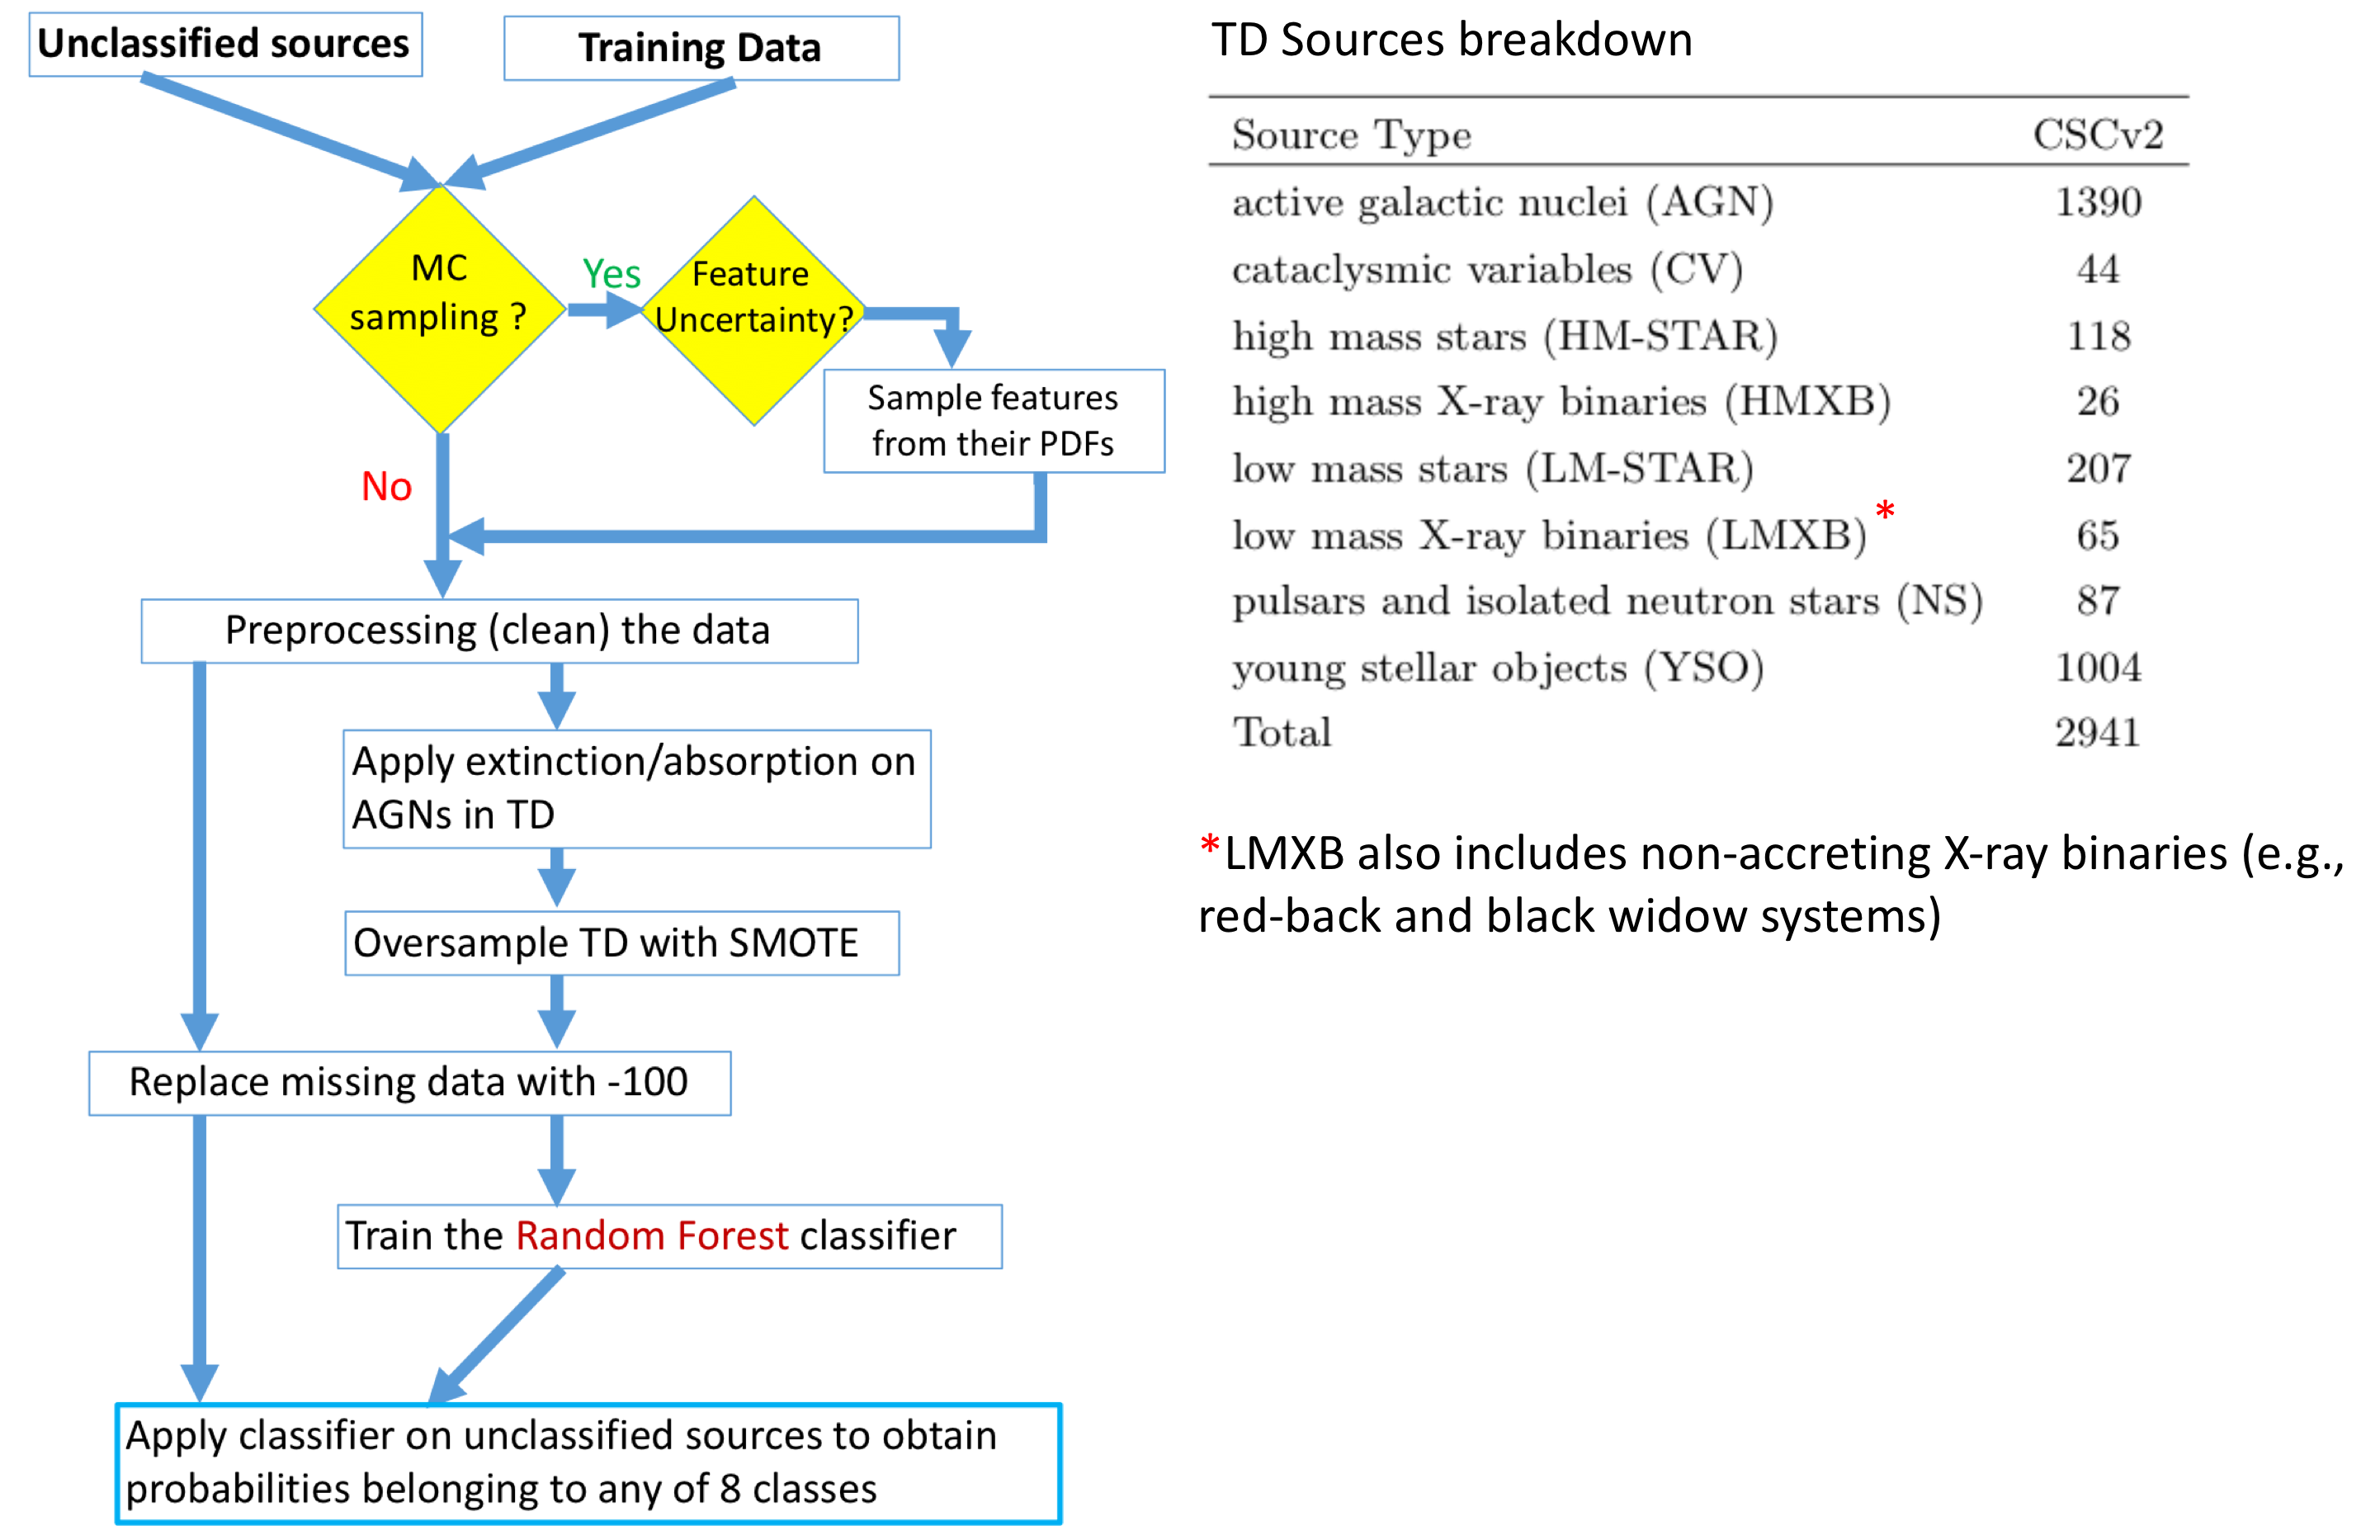

In [2]:
display(Image(filename='../files/figs/flowchart_TD_breakdown.png',width = 600))

Define a circular region of interest with detections available from CSCv2 (ACIS chips only)

* field_name
* RA, DEC, radius: RA (right ascension) and Dec (declination) coordinates and radius (in arcmin) of the field
* 

In [3]:

# dictionary of cluster name and CSCview cone search parameters. Radius is in arcmins
clusters_dict = {'NGC3532': {'ra': 166.28875, 'dec': -58.85, 'radius': 12, 'create_perobs': False},
'Trumpler18': {'ra': 167.9712649, 'dec': -60.6184559, 'radius': 12, 'create_perobs': True},
'IC2395': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 12, 'create_perobs': True},
'IC2395_CXO': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 12, 'create_perobs': True},
'IC2395_CXO_noconversion': {'ra': 130.6191230, 'dec': -48.1137862, 'radius': 12, 'create_perobs': True},
'NGC2169': {'ra': 92.1011374, 'dec': 13.9711171, 'radius': 12, 'create_perobs': True},
'NGC2169_CXO': {'ra': 92.1011374, 'dec': 13.9711171, 'radius': 12, 'create_perobs': True},
'NGC7160': {'ra': 328.4575412, 'dec': 62.5926872, 'radius': 12, 'create_perobs': True},
'J1256.9+2736': {'ra': 194.2417, 'dec': 27.6076, 'radius': 0.2127*60, 'create_perobs': True},
'J1435.4+3338': {'ra': 218.8526, 'dec': 33.6367, 'radius': 0.1853*60, 'create_perobs': True},
'J1115.1-6118': {'ra': 168.7757, 'dec': -61.3085, 'radius': 0.0373*60, 'create_perobs': True},
}

# select cluster
field_name = 'J1115.1-6118'
RA = clusters_dict[field_name]['ra']
DEC = clusters_dict[field_name]['dec']
radius = clusters_dict[field_name]['radius']



# creating the directories for saving the data and results 

data_dir = f'./data/{field_name}' # data directory to save the file

dir_out = f'./data/{field_name}' # classification results directory
dir_plot = dir_out+'/plot' # plots directory
nway_dir = f'./data/{field_name}/nway' 
Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(dir_out).mkdir(parents=True, exist_ok=True)
Path(dir_plot).mkdir(parents=True, exist_ok=True)
Path(nway_dir).mkdir(parents=True, exist_ok=True)

## Search for CSC sources and crossmatch to MW catalogs

In [5]:
# df = pd.read_csv(f'./data/{field_name}/{field_name}_ave.csv')


query_dir = f'./data'
template_dir = '../data'
astrometry_correct = False

CSCviewsearch(field_name, RA, DEC, radius, query_dir, template_dir,csc_version='2.0', engine='wget')


--2024-03-07 09:07:06--  http://cda.cfa.harvard.edu/csccli/getProperties?query=SELECT%20DISTINCT%20dbo.separation(m.ra,m.dec,168.7757,-61.3085)%20as%20separation,m.name,m.ra,m.dec,m.err_ellipse_r0,m.err_ellipse_r1,m.err_ellipse_ang,m.significance,m.likelihood_class,m.conf_flag,m.dither_warning_flag,m.extent_flag,m.pileup_flag,m.sat_src_flag,m.streak_src_flag,m.var_flag,m.var_inter_hard_flag,m.flux_aper90_b,m.flux_aper90_lolim_b,m.flux_aper90_hilim_b,m.flux_aper90_h,m.flux_aper90_lolim_h,m.flux_aper90_hilim_h,m.flux_aper90_m,m.flux_aper90_lolim_m,m.flux_aper90_hilim_m,m.flux_aper90_s,m.flux_aper90_lolim_s,m.flux_aper90_hilim_s,m.flux_aper90_avg_b,m.flux_aper90_avg_lolim_b,m.flux_aper90_avg_hilim_b,m.flux_aper90_avg_h,m.flux_aper90_avg_lolim_h,m.flux_aper90_avg_hilim_h,m.flux_aper90_avg_m,m.flux_aper90_avg_lolim_m,m.flux_aper90_avg_hilim_m,m.flux_aper90_avg_s,m.flux_aper90_avg_lolim_s,m.flux_aper90_avg_hilim_s,m.var_intra_index_b,m.var_intra_prob_b,m.ks_intra_prob_b,m.kp_intra_prob_b,m.v

In [6]:

df = pd.read_csv(f'{data_dir}/{field_name}_wget.txt', comment='#', sep='\t', na_values=' '*9)
df = df.drop_duplicates(subset=['name']).reset_index(drop=True)
df['ra'] = Angle(df['ra'], 'hourangle').degree
df['dec']= Angle(df['dec'], 'deg').degree
df['name'] = df['name'].str.strip()
print(len(df))

# df.columns

288


Index(['separation', 'name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1',
       'err_ellipse_ang', 'significance', 'likelihood_class', 'conf_flag',
       ...
       'flux_aper90_lolim_s.1', 'flux_aper90_hilim_s.1', 'var_index_b',
       'var_prob_b', 'ks_prob_b', 'kp_prob_b', 'var_sigma_b', 'var_mean_b',
       'var_min_b', 'var_max_b'],
      dtype='object', length=166)

In [7]:

df = pd.read_csv(f'{data_dir}/{field_name}_wget.txt', comment='#', sep='\t', na_values=' '*9)
df = df.drop_duplicates(subset=['name']).reset_index(drop=True)
df['ra'] = Angle(df['ra'], 'hourangle').degree
df['dec']= Angle(df['dec'], 'deg').degree
df['name'] = df['name'].str.strip()
print(len(df))
if astrometry_correct:
    # astrometric correction on the stack level 

    stack_astrometry(field_name, RA, DEC, radius, query_dir,template_dir,plotting=True)

    df_PU = pd.read_csv(f'{data_dir}/astrometry/{field_name}_PU.csv')
    print(len(df_PU))
    df = pd.merge(df, df_PU[['name','RA_new','DEC_new','r0_new','r1_new','ang_new']], on='name')
    print(len(df))
else:
    df['RA_new'],df['DEC_new'],df['r0_new'],df['r1_new'],df['ang_new'] = df['ra'],df['dec'],df['err_ellipse_r1'],df['err_ellipse_r0'],df['err_ellipse_ang']
    # df = df.rename(columns={'ra':'RA_new','dec':'DEC_new','err_ellipse_r0':'r0_new','err_ellipse_r1':'r1_new','err_ellipse_ang':'ang_new'})


288


### cross-matching each X-ray source to mutiwavelength counterparts using NWAY, this may take a few minutes depending on how many sources (4 minutes for ~300 sources)

## 

In [9]:
args = [(df, field_name, i, data_dir,'name','RA_new','DEC_new','r0_new','r1_new','ang_new',False,False,2,True,False,13) for i in range(len(df))]

if __name__ == '__main__': 
    with mp.Pool() as pool:
        arr = pool.map(nway_CSC_matching_merged_mw, args)

## Process crossmatching results

In [10]:
df_fields = process_crossmatching(df, data_dir, field_name)

## Classify

#### MUWCLASS pipeline settings

In [11]:
TD = pd.read_csv('../files/CSC_TD_11042023_MW_allcolumns.csv')
TD = TD.rename(columns={'GAIA_DR3Name': 'DR3Name_gaia', 'GAIA_rgeo': 'rgeo', 'GAIA_B_rgeo': 'B_rgeo', 'GAIA_b_rgeo': 'b_rgeo', 'GAIA_rpgeo': 'rpgeo', 'GAIA_B_rpgeo': 'B_rpgeo', 'GAIA_b_rpgeo': 'b_rpgeo'})

dir_tool = '../files'

# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt(f'{dir_tool}/tbabs.data', skiprows=0)
tbabs_cross *= 100

df_reds = []
df_extinction = pd.read_csv(f'{dir_tool}/extinction_MWbands.csv',index_col='ebv_index')
df_reds.append(df_extinction)
df_abs = []
for band in ['Fcsc_s', 'Fcsc_m', 'Fcsc_h', 'Fcsc_b']:
        df_abs_band = pd.read_csv(f'{dir_tool}/abs_{band}.csv',index_col='nH')
        df_abs_band = df_abs_band.stack() 
        df_abs_band= df_abs_band.reset_index().rename(columns={'nH':'nH_index','level_1':'Gamma_col',0:band+'_cor'})
        df_abs_band = df_abs_band.set_index(['nH_index','Gamma_col'])
        df_abs.append(df_abs_band)
df_reds.append(df_abs)

#start_t = datetime.datetime.now()


Xcat = 'CSC'
distance = 'nodist' # 'rgeo_lum'
ran_feature = False
# seed for generating all randomness, set to none for random seed
random_state_sample, random_state_smote,random_state_rf = None, None, None #12, 12, 12 #random_state, random_state, random_state
Uncer_flag = True
red_switch = True
apply_limit= True
mag2flux_switch= True
stand_switch= True
# SMOTE oversampling switch
oversample_switch = True # True
scaler_switch=True
color_select = True
# physical oversampling switch
physical_sample = True
Xfeature_only = False
missingvalues_replace = True
ML_model = 'RF'

n_estimators = 1000 # 1000

num_sample = 10 #10 for test, 1000 for real run

class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 

version = 'default' # 'default'#   'SMOTE' # lightGBM'


Run classification in parallel. If crashes, make sure enough memory is allocated. 

In [12]:
df_all = pd.DataFrame()
# field_name = 
# for field_name in df_fields['Field'].unique():
print(field_name)

start = time.time()

df_field = df_fields #[df_fields['Field']==field_name].reset_index(drop=True)
df_field = df_field.sort_values(by='name').reset_index(drop=True)

df_field.to_csv(f'{data_dir}/{field_name}_MW.csv',index=False)

df_field['ebv'] = DustMap.ebv(SkyCoord(df_field['CSC_RA'],df_field['CSC_DEC'], unit='deg'), dustmap='SFD') * 0.86

# create list of args to pass to multiprocessing pool. assign i to random state variables to set reproducible results
args = [(TD,df_field,red_switch,df_field['ebv'].mean(),Xcat,False,distance,Uncer_flag,random_state_sample,random_state_smote,tbabs_ene,tbabs_cross,\
            apply_limit,mag2flux_switch,stand_switch,oversample_switch,scaler_switch,color_select,np.sqrt(2.),physical_sample,df_reds,Xfeature_only,missingvalues_replace) for i in range(num_sample)]


print('Preprocessing')
if __name__ == '__main__': 
    with mp.Pool() as pool:
        arr = pool.map(class_prepare_FGL, args)
        
        
opts = {'bootstrap': True, 'class_weight': None, 'criterion': 'gini',
        'max_depth': None,  'max_leaf_nodes': None, # 'max_features': "auto",
        'min_samples_leaf': 1, 'min_samples_split': 2,
        'min_weight_fraction_leaf': 0.0, 'n_jobs': None,#-1,
        'random_state': None, 'verbose': 0, 'warm_start': False,
        'n_estimators': n_estimators}


arr = [_ for _ in zip(arr, [ML_model]*len(arr), [opts]*len(arr), [False]*len(arr))]
print('Classifying')
if __name__ == '__main__': 
    with mp.Pool() as pool:
        #res = pool.map(class_train_and_classify, arr)
        res = pool.map(class_train_model_and_classify, arr)

class_save_res(res, dir_out)
end = time.time()
print(end - start)

#FGL_radius,FGL_ra, FGL_dec = fgl_unas.loc[fgl_unas.FGL_name==field_name, 'Conf_95_SemiMajor'].values[0], fgl_unas.loc[fgl_unas.FGL_name==field_name, 'RAJ2000'].values[0], fgl_unas.loc[fgl_unas.FGL_name==field_name, 'DEJ2000'].values[0]
df_class = combine_class_result(field_name, data_dir, class_labels)#,weight_CM=True)

df_all = pd.concat([df_all, df_class], ignore_index=True, sort=False)
df_XCLASS = df_class.rename(columns={'significance':'Signif.','F_b':'flux_aper90_ave_b','Fcsc_s':'flux_aper90_ave_s','Fcsc_m':'flux_aper90_ave_m','Fcsc_h':'flux_aper90_ave_h','var_intra_prob':'kp_prob_b_max','W1mag':'W1mag_comb','W2mag':'W2mag_comb'})


    
df_all.to_csv(f'{data_dir}/{field_name}_class.csv',index=False)

J1115.1-6118
Preprocessing


/Users/huiyang/Research/GitHub/MUWCLASS_testing/MUWCLASS-main/demos/../physical_oversampling.py:332: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_res[band+'_cor'] = np.nan
/Users/huiyang/Research/GitHub/MUWCLASS_testing/MUWCLASS-main/demos/../physical_oversampling.py:332: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_res[band+'_cor'] = np.nan
/Users/huiyang/Research/GitHub/MUWCLASS_testing/MUWCLASS-main/demos/../physical_oversampling.py:332: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

Classifying
86.14008283615112


Create visualization website

In [13]:
df_all = pd.read_csv(f'{data_dir}/{field_name}_class.csv')

df_html = df_all[['name','Class','Class_prob','Class_prob_e','CT','CSC_RA','CSC_DEC','CSC_err_r0','CSC_err_r1','CSC_PA','significance','Fcsc_b','Fcsc_s','Fcsc_m','Fcsc_h','HR_hms','var_intra_prob',
       'var_inter_prob','p_any','p_i','MW_RA','MW_DEC','MW_err0','MW_sep','DR3Name_gaia','CATWISE_Name','ALLWISE_AllWISE','TMASS__2MASS','Gmag','BPmag','RPmag','RPlx','PM','rgeo','Jmag','Hmag','Kmag','W1mag','W2mag','W3mag']].rename(columns={'DR3Name_gaia':'Gaia_DR3Name','ALLWISE_AllWISE':'AllWISE_Name','TMASS__2MASS':'TMASS_Name'})


In [14]:
write_to_html_file(df_html, clusters_dict, field_name, filename=f'./data/{field_name}/{field_name}_class.html')
os.system(f'open ./data/{field_name}/{field_name}_class.html')

0